In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
from PIL.ExifTags import TAGS
from statsmodels.distributions.empirical_distribution import ECDF

In [13]:
april_pure_1 = cv2.imread("april_tag_pure_1.png", 0)
april_pure_1 = cv2.copyMakeBorder(april_pure_1, 400, 400, 400, 400, cv2.BORDER_CONSTANT, value=255)

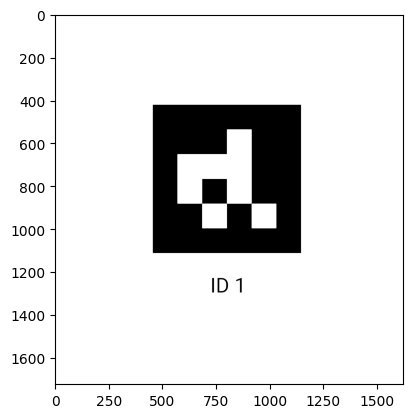

In [14]:
plt.imshow(april_pure_1, cmap="Greys_r")

In [24]:
april_pure_1.shape

(1723, 1621)

In [254]:
euc_image_coords = np.indices(april_pure_1.shape)[::-1, :, :]
euc_image_coords[1, :, :] = april_pure_1.shape[0] - 1 - euc_image_coords[1, :, :]
hc_image_coords = np.append(
    euc_image_coords,
    np.ones((1, *april_pure_1.shape), dtype=euc_image_coords.dtype),
    axis=0
)
wide_hc_coords = hc_image_coords \
    .reshape((hc_image_coords.shape[0], hc_image_coords.shape[1] * hc_image_coords.shape[2]))
coord_offset = (np.max(wide_hc_coords, axis=1) / 2).astype(int).reshape(3, 1)
wide_hc_coords = wide_hc_coords - coord_offset

# Translation

In [443]:
translation_matrix = np.array([[1, 0, -300], [0, 1, 200], [0, 0, 1]])
translated_hc_coords = np.dot(translation_matrix, wide_hc_coords) \
    .reshape(hc_image_coords.shape)[:2, :, :] \
    .astype(int)

translated_hc_coords[0, :, :] = translated_hc_coords[0, :, :] + coord_offset[0]
translated_hc_coords[1, :, :] = translated_hc_coords[1, :, :] + coord_offset[1]
coord_shift = euc_image_coords - translated_hc_coords
translated_hc_coords = euc_image_coords + coord_shift
translated_hc_coords[1, :, :] = translated_hc_coords[1, :, :][::-1]

new_matrix = np.empty(april_pure_1.shape, dtype=april_pure_1.dtype) + 255
for i in range(april_pure_1.shape[0]):
    for j in range(april_pure_1.shape[1]):
        x = translated_hc_coords[0, i, j]
        y = translated_hc_coords[1, i, j]

        in_view = (0 <= x < april_pure_1.shape[1]) and (0 <= y < april_pure_1.shape[0])

        if in_view:
            new_matrix[i, j] = april_pure_1[y, x]

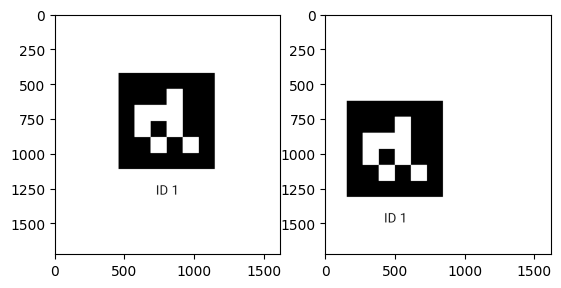

In [444]:
plt.subplot(121)
plt.imshow(april_pure_1, cmap="Greys_r")
plt.subplot(122)
plt.imshow(new_matrix, cmap="Greys_r")

In [409]:
translation_matrix = np.array([[1, 0, 0], [0, 1, -800], [0, 0, 1]])
translated_hc_coords = np.dot(translation_matrix, wide_hc_coords) \
    .reshape(hc_image_coords.shape)[:2, :, :] \
    .astype(int)

translated_hc_coords[0, :, :] = translated_hc_coords[0, :, :] + coord_offset[0]
translated_hc_coords[1, :, :] = translated_hc_coords[1, :, :] + coord_offset[1]
coord_shift = euc_image_coords - translated_hc_coords
translated_hc_coords = euc_image_coords + coord_shift

new_matrix = np.empty(april_pure_1.shape, dtype=april_pure_1.dtype) + 255
new_matrix = april_pure_1[translated_hc_coords[1], translated_hc_coords[0]]

"""
new_coord_filter = np.logical_and(
    translated_hc_coords[0] >= 0, translated_hc_coords[0] < april_pure_1.shape[1]
    ) \
    & np.logical_and(
    translated_hc_coords[1] >= 0, translated_hc_coords[1] < april_pure_1.shape[0]
    )

new_coords = np.where(new_coord_filter, translated_hc_coords, euc_image_coords)
new_coords[1, :, :] = new_coords[1, :, :][::-1]
na_fills = np.empty(april_pure_1.shape, dtype=april_pure_1.dtype) + 255
new_matrix = np.where(
    (np.abs(coord_shift)[0] > 0) | (np.abs(coord_shift)[1] > 0),
    april_pure_1[new_coords[1], new_coords[0]], na_fills
)
"""

IndexError: index 2522 is out of bounds for axis 0 with size 1723

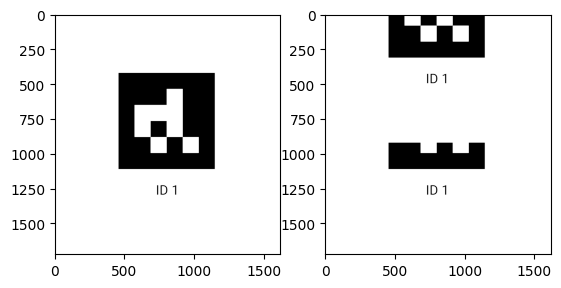

In [406]:
plt.subplot(121)
plt.imshow(april_pure_1, cmap="Greys_r")
plt.subplot(122)
plt.imshow(new_matrix, cmap="Greys_r")

In [326]:
translation_matrix = np.array([[1, 0, -700], [0, 1, 0], [0, 0, 1]])
translated_hc_coords = np.dot(translation_matrix, wide_hc_coords) \
    .reshape(hc_image_coords.shape)[:2, :, :] \
    .astype(int)
translated_hc_coords[1, :, :] = translated_hc_coords[1, :, :][::-1]

translated_hc_coords[0, :, :] = translated_hc_coords[0, :, :] + coord_offset[0]
translated_hc_coords[1, :, :] = translated_hc_coords[1, :, :] + coord_offset[1]

clipped_coords = np.clip(translated_hc_coords, 0, None)
trans_row_inds, trans_col_inds = clipped_coords

new_dims = (np.max(np.max(translated_hc_coords, axis=(1)), axis=1) + 1)[::-1]
new_dims = np.max(np.vstack([new_dims, np.array(april_pure_1.shape)]), axis=0)
new_matrix = np.empty(new_dims, dtype=april_pure_1.dtype) + 255
new_matrix[trans_col_inds, trans_row_inds] = np.where(
    (translated_hc_coords[0, :, :] >= 0) & (translated_hc_coords[1, :, :] >= 0),
    april_pure_1,
    new_matrix[:april_pure_1.shape[0], :april_pure_1.shape[1]]
)
new_matrix = new_matrix[:april_pure_1.shape[0], :april_pure_1.shape[1]]

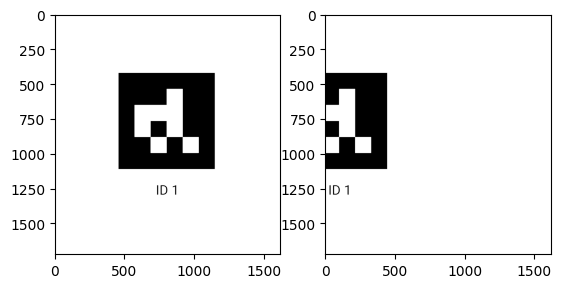

In [327]:
plt.subplot(121)
plt.imshow(april_pure_1, cmap="Greys_r")
plt.subplot(122)
plt.imshow(new_matrix, cmap="Greys_r")

In [329]:
euc_trans_image_coords = np.indices(new_matrix.shape)[::-1, :, :]
euc_trans_image_coords[1, :, :] = new_matrix.shape[0] - 1 - euc_trans_image_coords[1, :, :]
hc_trans_image_coords = np.append(
    euc_trans_image_coords,
    np.ones((1, *new_matrix.shape), dtype=euc_trans_image_coords.dtype),
    axis=0
)
wide_hc_trans_coords = hc_trans_image_coords \
    .reshape((
        hc_trans_image_coords.shape[0], hc_trans_image_coords.shape[1] * hc_trans_image_coords.shape[2]
    ))
coord_offset = (np.max(wide_hc_trans_coords, axis=1) / 2).astype(int).reshape(3, 1)
wide_hc_trans_coords = wide_hc_trans_coords - coord_offset

In [185]:
inv_translation_matrix = np.linalg.inv(translation_matrix)
inverted_hc_coords = np.dot(inv_translation_matrix, wide_hc_trans_coords) \
    .reshape(hc_trans_image_coords.shape)[:2, :, :] \
    .astype(int)
inverted_hc_coords[1, :, :] = inverted_hc_coords[1, :, :][::-1]

inverted_hc_coords[0, :, :] = inverted_hc_coords[0, :, :] + coord_offset[0]
inverted_hc_coords[1, :, :] = inverted_hc_coords[1, :, :] + coord_offset[1]

clipped_coords = np.clip(inverted_hc_coords, 0, None)
inv_row_inds, inv_col_inds = clipped_coords

new_dims = (np.max(np.max(inverted_hc_coords, axis=(1)), axis=1) + 1)[::-1]
new_dims = np.max(np.vstack([new_dims, np.array(new_matrix.shape)]), axis=0)
inv_matrix = np.empty(new_dims, dtype=new_matrix.dtype) + 255
inv_matrix[inv_col_inds, inv_row_inds] = new_matrix
new_matrix[trans_col_inds, trans_row_inds] = np.where(
    (translated_hc_coords[0, :, :] >= 0) & (translated_hc_coords[1, :, :] >= 0),
    april_pure_1,
    new_matrix[:april_pure_1.shape[0], :april_pure_1.shape[1]]
)
inv_matrix = inv_matrix[:new_matrix.shape[0], :new_matrix.shape[1]]

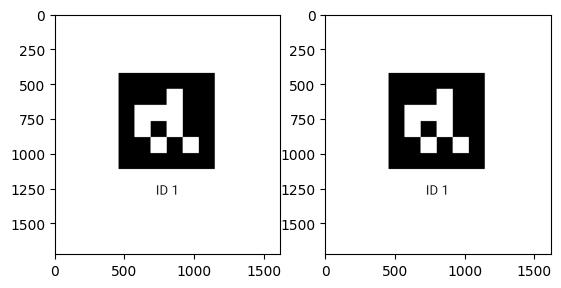

In [186]:
plt.subplot(121)
plt.imshow(april_pure_1, cmap="Greys_r")
plt.subplot(122)
plt.imshow(inv_matrix, cmap="Greys_r")

# Rotation

In [233]:
rotation_matrix = np.identity(3)
angle_of_rotation = np.deg2rad(45)
cos_of_angle = np.cos(angle_of_rotation)
sin_of_angle = np.sin(angle_of_rotation)
rotation_base = np.array([[cos_of_angle, -1 * sin_of_angle], [sin_of_angle, cos_of_angle]])
rotation_matrix[:2, :2] = rotation_base
rotated_hc_coords = np.dot(rotation_matrix, wide_hc_coords) \
    .reshape(hc_image_coords.shape)[:2, :, :] \
    .astype(int)
rotated_hc_coords[1, :, :] = rotated_hc_coords[1, :, :][::-1]
rot_row_inds, rot_col_inds = rotated_hc_coords

new_dims = (np.max(np.max(np.abs(rotated_hc_coords), axis=1), axis=1) + 1)[::-1]
new_dims = np.max(np.vstack([new_dims, np.array(april_pure_1.shape)]), axis=0)
new_matrix = np.empty(new_dims, dtype=april_pure_1.dtype) + 255
new_matrix[rot_col_inds, rot_row_inds] = april_pure_1
new_matrix = new_matrix[:april_pure_1.shape[0], :april_pure_1.shape[1]]

(1723, 1621)

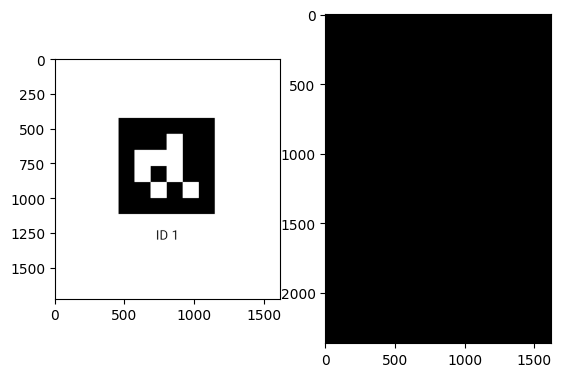

In [234]:
plt.subplot(121)
plt.imshow(april_pure_1, cmap="Greys_r")
plt.subplot(122)
plt.imshow(new_matrix, cmap="Greys_r")

In [ ]:
translation_matrix = np.array([[1, 0, 300], [0, 1, 200], [0, 0, 1]])
translated_hc_coords = np.dot(translation_matrix, wide_hc_coords) \
    .reshape(hc_image_coords.shape)[:2, :, :] \
    .astype(int)
translated_hc_coords[1, :, :] = translated_hc_coords[1, :, :][::-1]
trans_row_inds, trans_col_inds = translated_hc_coords

new_dims = (np.max(np.max(translated_hc_coords, axis=(1)), axis=1) + 1)[::-1]
new_dims = np.max(np.vstack([new_dims, np.array(april_pure_1.shape)]), axis=0)
new_matrix = np.empty(new_dims, dtype=april_pure_1.dtype) + 255
new_matrix[trans_col_inds, trans_row_inds] = april_pure_1
new_matrix = new_matrix[:april_pure_1.shape[0], :april_pure_1.shape[1]]